In [2]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import gsw
import xgcm 
from xmitgcm import open_mdsdataset
import MITgcmutils.mnc as mnc
import matplotlib.cm as cm

In [3]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [4]:
path='run_flat_tw/'
dss = open_mncdataset(path+'/state', 2, 3, 0)
dsg = open_mncdataset(path+'/grid', 2, 3, None)
ds=xr.merge((dss,dsg))
ds=ds.isel(Zp1=slice(0,-1))
ds=ds.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
ds = xgcm.generate_grid_ds(ds, {'X':'X', 'Y':'Y', 'Z':'Z'})
ds['drU']=ds.U.isel(T=0)*0+ds.drF.isel(X=30,Y=20)
ds['drV']=ds.V.isel(T=0)*0+ds.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(ds, periodic=False,metrics=metrics)
ds.coords['day']=ds.T/(24*3600)
ds

<xarray.Dataset>
Dimensions:  (T: 123, X: 60, X_left: 60, Y: 40, Y_left: 40, Z: 100, Z_left: 100, Zl: 100, Zu: 100)
Coordinates: (12/13)
    Yp1      (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    Xp1      (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * T        (T) float64 0.0 2.592e+06 5.184e+06 ... 3.136e+08 3.154e+08
  * Y        (Y) float64 1.25e+04 3.75e+04 6.25e+04 ... 9.625e+05 9.875e+05
  * Z        (Z) float64 -20.0 -60.0 -100.0 ... -3.9e+03 -3.94e+03 -3.98e+03
  * X        (X) float64 1.25e+04 3.75e+04 6.25e+04 ... 1.462e+06 1.488e+06
    ...       ...
    Zp1      (Z_left) float64 0.0 -40.0 -80.0 ... -3.88e+03 -3.92e+03 -3.96e+03
  * Zu       (Zu) float64 -40.0 -80.0 -120.0 ... -3.92e+03 -3.96e+03 -4e+03
  * X_left   (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * Y_left   (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
  * Z_left   (Z_left) float64 0.0 -40.0 -80.0 ... -3.88e+03 -3.92e+03 -3.96e+03
    day      (T) float64 0.0 30.0 60.0 90.0 ... 3.6e+03 3.63e+03 3.65e+03
Data variables: (12/39)
    iter     (Y, X, T) int32 dask.array<chunksize=(20, 20, 123), meta=np.ndarray>
    U        (T, Z, Y, X_left) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    V        (T, Z, Y_left, X) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    Temp     (T, Z, Y, X) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    S        (T, Z, Y, X) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    Eta      (T, Y, X) float32 dask.array<chunksize=(123, 20, 20), meta=np.ndarray>
    ...       ...
    Depth    (Y, X) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    HFacC    (Z, Y, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    HFacW    (Z, Y, X_left) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    HFacS    (Z, Y_left, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    drU      (Z, Y, X_left) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    drV      (Z, Y_left, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>

Text(0.5, 1.0, 'u-velocity [m/s]}')

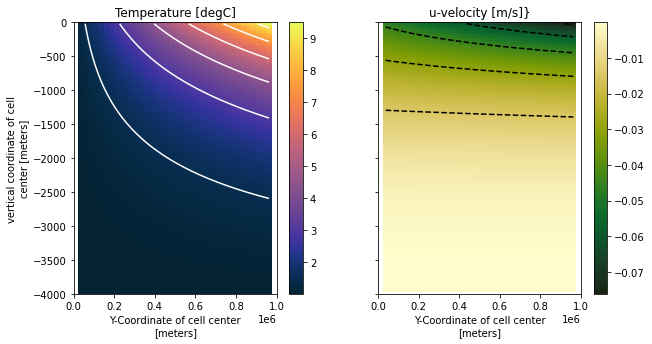

In [5]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
ds.Temp.where(ds.Temp>0).isel(X=58,T=0).plot.pcolormesh(cmap=cmo.thermal,ax=axes[0],cbar_kwargs={'label':''})
ds.Temp.where(ds.Temp>0).isel(X=58,T=0).plot.contour(colors='white',ax=axes[0])#cbar_kwargs={'label':''})
ds.U.where(ds.U<0).isel(X_left=59,T=0).plot.pcolormesh(cmap=cmo.speed_r,ax=axes[1],cbar_kwargs={'label':''})
ds.U.where(ds.U<0).isel(X_left=59,T=0).plot.contour(colors='k',ax=axes[1])#,cbar_kwargs={'label':''})
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[0].set_title('Temperature [degC]')
axes[1].set_title('u-velocity [m/s]}')

In [6]:
# Estimate Rossby number: 
# Ro=U/fL
# Alverson &Owens use Ro=0.08
U=-0.1
f=ds.fCori.mean()
L=150e3

Ro=U/(f*L)

print(Ro.values)

0.005306376938485827


In [7]:
# compute streamfunctions for all along U since the boundaries are closed
psi = grid.cumint(-grid.integrate(ds.U,'Z'),'Y', boundary='fill')/1e6
# relative vorticity
ze=-1*grid.derivative(ds.U,'Y',boundary='extend')+(grid.derivative(ds.V,'X',boundary='extend'))

Text(0.5, 1.0, 'relative vorticity')

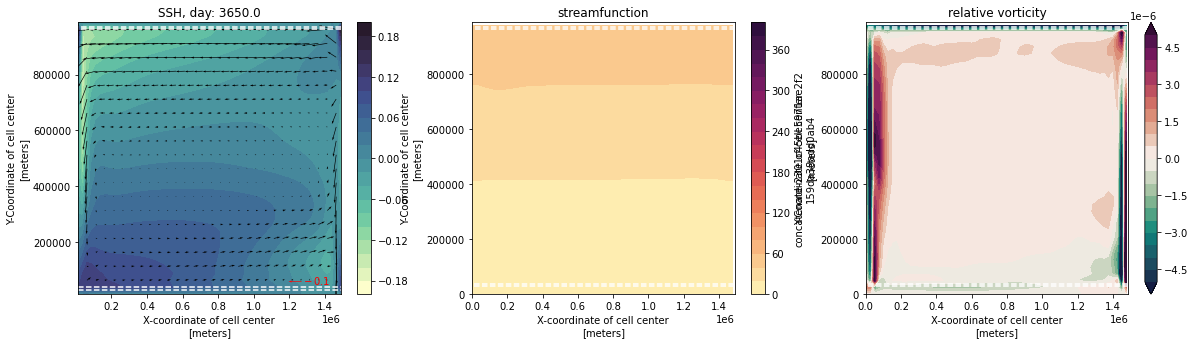

In [8]:
arr=2
wmin=-.2
wmax=.2
cmap2=cmo.deep
lev=21
t=-1
fig,axes=plt.subplots(1,3,figsize=(20,5))
(ds.Eta.isel(T=t)-ds.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=axes[0],cbar_kwargs={'label':''})
ds.Depth.plot.contour(levels=[2500,3999],ax=axes[0],linestyles='--',colors='w')
q=axes[0].quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
axes[0].quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
axes[0].set_title(f'SSH, day: {ds.T.isel(T=t).values/(24*3600)}')

arr=4
wmin=0
wmax=400
lev=21
cmap2=cmo.matter
(psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=axes[1])
ds.Depth.plot.contour(levels=[2500,3999],ax=axes[1],linestyles='--',colors='w')
#axes[0].quiver(ds.X[::arr],ds.Y[::arr],grid.interp(ds.isel(T=t,Z=0).U,'X')[::arr,::arr],grid.interp(ds.isel(T=t,Z=0).V,'Y')[::arr,::arr])
axes[1].set_title(f'streamfunction')

arr=4
wmin=-5e-6
wmax=-1*wmin
lev=21
cmap2=cmo.curl
dep=0
(ze.isel(T=t,Z=dep)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=axes[2])
ds.Depth.plot.contour(levels=[2500,3999],ax=axes[2],linestyles='--',colors='w')
axes[2].set_title(f'relative vorticity')


In [9]:
speed=np.sqrt((grid.interp(ds.V,'Y',boundary="extend"))**2+(grid.interp(ds.U,'X',boundary="extend"))**2)
speed

<xarray.DataArray (T: 123, Z: 100, Y: 40, X: 60)>
dask.array<sqrt, shape=(123, 100, 40, 60), dtype=float32, chunksize=(123, 100, 19, 19), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) float64 0.0 2.592e+06 5.184e+06 ... 3.136e+08 3.154e+08
  * Z        (Z) float64 -20.0 -60.0 -100.0 ... -3.9e+03 -3.94e+03 -3.98e+03
  * Y        (Y) float64 1.25e+04 3.75e+04 6.25e+04 ... 9.625e+05 9.875e+05
  * X        (X) float64 1.25e+04 3.75e+04 6.25e+04 ... 1.462e+06 1.488e+06

Text(0.5, 1.0, ' Thermal wind- day:3650.0 - depth:-20.0m')

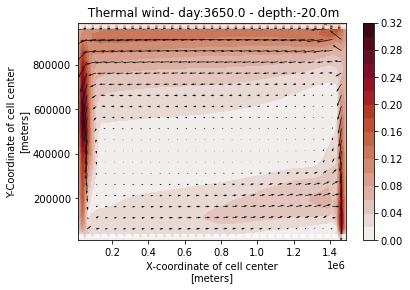

In [10]:
tt=-1
arr=2
zz=0
plt.figure()
speed.isel(Z=zz,T=tt).plot.contourf(cmap=cmo.amp,levels=lev,cbar_kwargs={'label':''})
plt.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=tt,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=tt,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],linestyles='--',colors='w')
plt.title(f' Thermal wind- day:{ds.day.isel(T=tt).values} - depth:{ds.Z.isel(Z=zz).values}m')

[Text(0, -4000.0, ''),
 Text(0, -3500.0, ''),
 Text(0, -3000.0, ''),
 Text(0, -2500.0, ''),
 Text(0, -2000.0, ''),
 Text(0, -1500.0, ''),
 Text(0, -1000.0, ''),
 Text(0, -500.0, ''),
 Text(0, 0.0, '')]

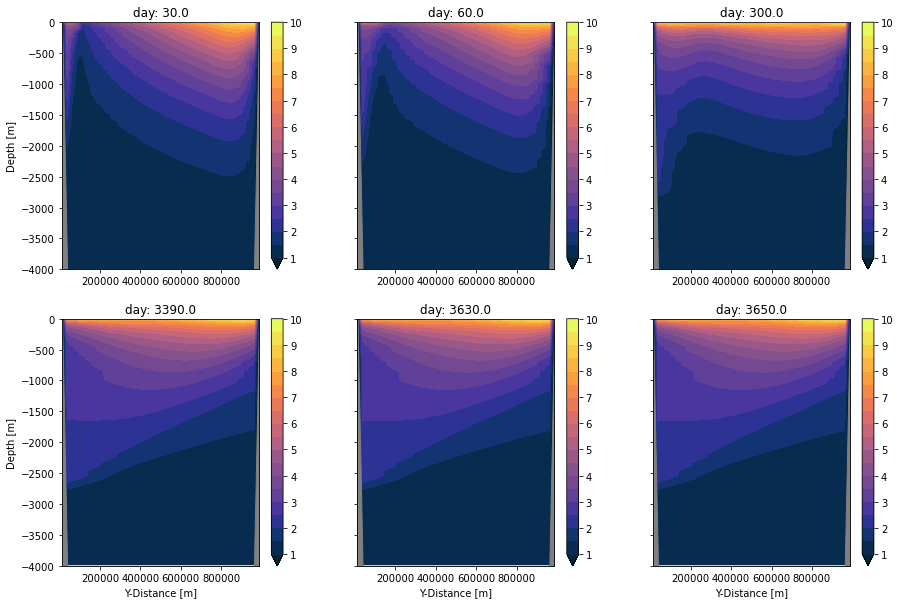

In [11]:
#plot relative vorticity at last time step
wmax=10
wmin=1
lev=19
cmap2=cmo.thermal
t=-1
xx=30
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
t=1
ds.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.Y,(-1*ds.Depth).isel(X=xx),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')
ax=axes[0,1]
t=2
ds.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.Y,(-1*ds.Depth).isel(X=xx),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
t=10
ds.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.Y,(-1*ds.Depth).isel(X=xx),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
t=-10
ds.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.Y,(-1*ds.Depth).isel(X=xx),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')
ax=axes[1,1]
t=-2
ds.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.Y,(-1*ds.Depth).isel(X=xx),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
t=-1
ds.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.Y,(-1*ds.Depth).isel(X=xx),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

[Text(0, -4000.0, ''),
 Text(0, -3500.0, ''),
 Text(0, -3000.0, ''),
 Text(0, -2500.0, ''),
 Text(0, -2000.0, ''),
 Text(0, -1500.0, ''),
 Text(0, -1000.0, ''),
 Text(0, -500.0, ''),
 Text(0, 0.0, '')]

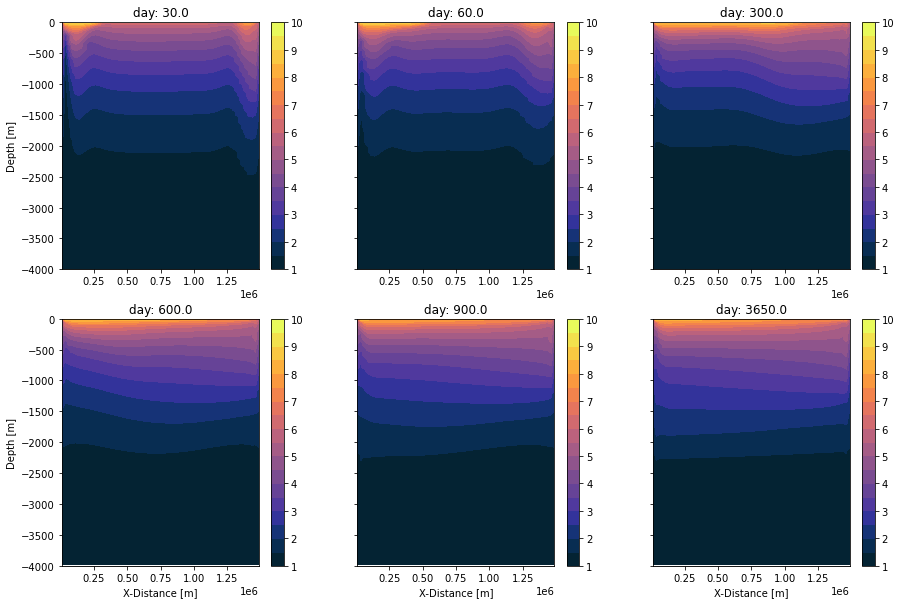

In [12]:
#plot relative vorticity at last time step
wmax=10
wmin=1
lev=19
cmap2=cmo.thermal
t=-1
yy=20
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
t=1
ds.Temp.isel(T=t,Y=yy).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.X,(-1*ds.Depth).isel(Y=yy),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')
ax=axes[0,1]
t=2
ds.Temp.isel(T=t,Y=yy).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.X,(-1*ds.Depth).isel(Y=yy),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
t=10
ds.Temp.isel(T=t,Y=yy).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.X,(-1*ds.Depth).isel(Y=yy),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
t=20
ds.Temp.isel(T=t,Y=yy).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.X,(-1*ds.Depth).isel(Y=yy),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')
ax=axes[1,1]
t=30
ds.Temp.isel(T=t,Y=yy).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.X,(-1*ds.Depth).isel(Y=yy),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
t=-1
ds.Temp.isel(T=t,Y=yy).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(ds.X,(-1*ds.Depth).isel(Y=yy),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

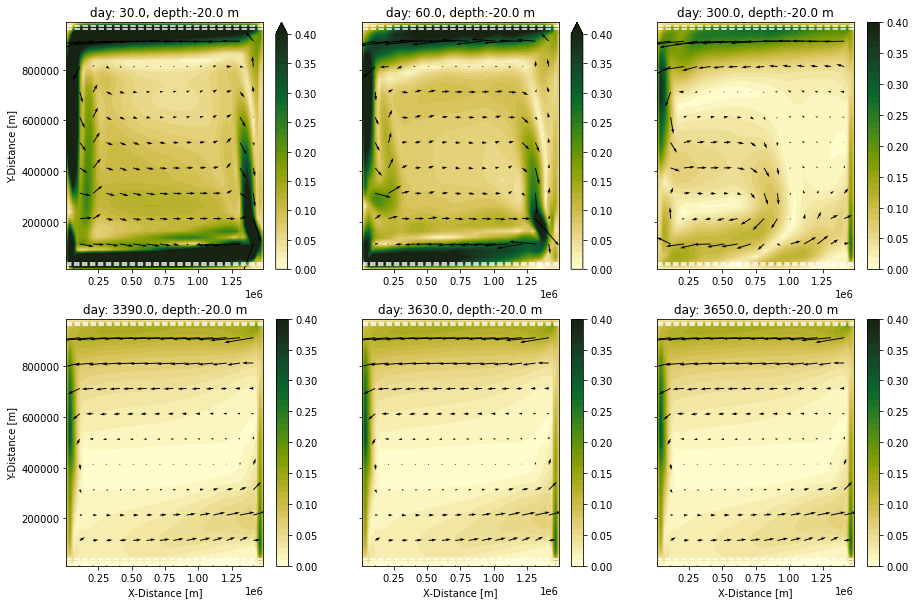

In [13]:

cmap2=cmo.speed
zz=0
wmin=0
wmax=0.4
lev=41
arr=4
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
t=1
speed.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}, depth:{ds.Z.isel(Z=zz).values} m')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax=axes[0,1]
t=2
speed.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}, depth:{ds.Z.isel(Z=zz).values} m')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
t=10
speed.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}, depth:{ds.Z.isel(Z=zz).values} m')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
t=-10
speed.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}, depth:{ds.Z.isel(Z=zz).values} m')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1,1]
t=-2
speed.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}, depth:{ds.Z.isel(Z=zz).values} m')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
t=-1
speed.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=t,Z=zz).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}, depth:{ds.Z.isel(Z=zz).values} m')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

In [14]:
path

'run_flat_tw/'

Text(0.5, 1.0, 'day: 3650.0, Depth:-20.0 m')

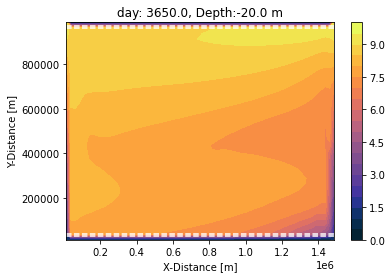

In [15]:
ds.Temp.isel(Z=0,T=-1).plot.contourf(cmap=cmo.thermal,levels=21,cbar_kwargs={'label':''})
ds.Depth.plot.contour(levels=[2500,3999],linestyles='--',colors='w')
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')
plt.title(f'day: {ds.day.isel(T=t).values}, Depth:{ds.Z.isel(Z=0).values} m')

Text(0.5, 1.0, 'day: 3650.0, Depth:-1020.0 m')

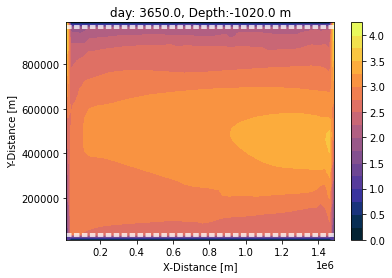

In [16]:
ds.Temp.isel(Z=25,T=-1).plot.contourf(cmap=cmo.thermal,levels=21,cbar_kwargs={'label':''})
ds.Depth.plot.contour(levels=[2500,3999],linestyles='--',colors='w')
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')
plt.title(f'day: {ds.day.isel(T=t).values}, Depth:{ds.Z.isel(Z=25).values} m')

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

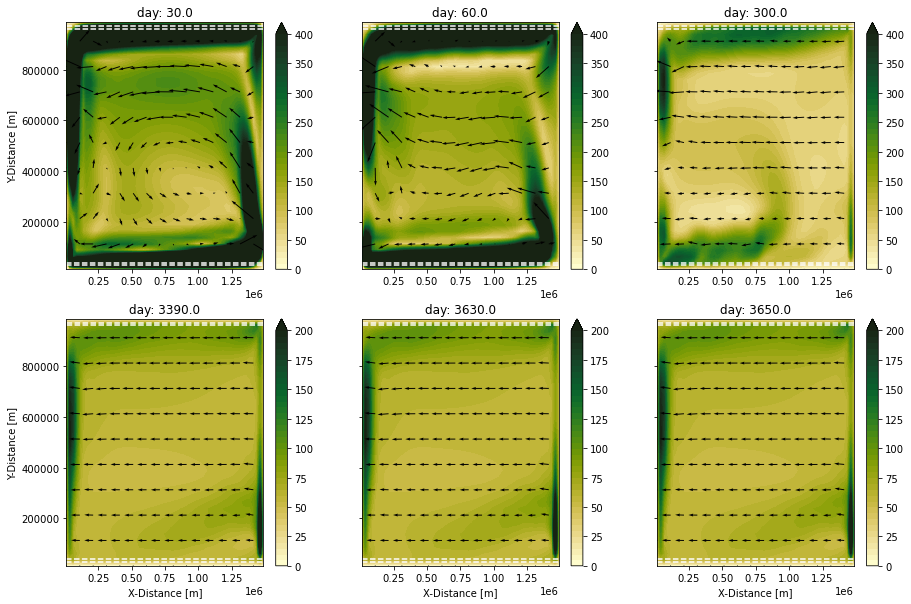

In [17]:

speed_intz=grid.integrate(speed,'Z')
U_intz=grid.integrate(grid.interp(ds.U,'X',boundary="extend"),'Z')
V_intz=grid.integrate(grid.interp(ds.V,'Y',boundary="extend"),'Z')

cmap2=cmo.speed
wmin=0
wmax=400
lev=41
arr=4
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
t=1
speed_intz.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],U_intz.isel(T=t)[0:-1:arr,0:-1:arr],V_intz.isel(T=t)[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax=axes[0,1]
t=2
speed_intz.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],U_intz.isel(T=t)[0:-1:arr,0:-1:arr],V_intz.isel(T=t)[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
t=10
speed_intz.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],U_intz.isel(T=t)[0:-1:arr,0:-1:arr],V_intz.isel(T=t)[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
t=-10
speed_intz.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin*.5,vmax=wmax*.5,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],U_intz.isel(T=t)[0:-1:arr,0:-1:arr],V_intz.isel(T=t)[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1,1]
t=-2
speed_intz.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin*.5,vmax=wmax*.5,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],U_intz.isel(T=t)[0:-1:arr,0:-1:arr],V_intz.isel(T=t)[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
t=-1
speed_intz.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin*.5,vmax=wmax*.5,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],U_intz.isel(T=t)[0:-1:arr,0:-1:arr],V_intz.isel(T=t)[0:-1:arr,0:-1:arr])
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {ds.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

Text(0.5, 1.0, 'day: 3650.0, Depth:-20.0 m')

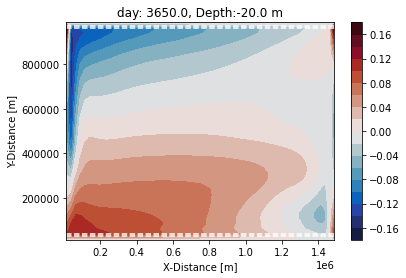

In [18]:
(ds.Eta.isel(T=-1)-ds.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmo.balance,levels=21,cbar_kwargs={'label':''})
ds.Depth.plot.contour(levels=[2500,3999],linestyles='--',colors='w')
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')
plt.title(f'day: {ds.day.isel(T=t).values}, Depth:{ds.Z.isel(Z=0).values} m')

Text(0.5, 1.0, 'day: 3650.0, Depth:-20.0 m')

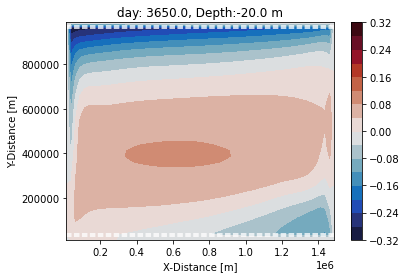

In [19]:
(ds.Eta.isel(T=-1)).plot.contourf(cmap=cmo.balance,levels=21,cbar_kwargs={'label':''})
ds.Depth.plot.contour(levels=[2500,3999],linestyles='--',colors='w')
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')
plt.title(f'day: {ds.day.isel(T=t).values}, Depth:{ds.Z.isel(Z=0).values} m')

In [56]:
path

'run_bump_tw_slip/'